# Mean Error Analysis

In [4]:
EXPORT_LATEX = True

%matplotlib inline 
# %matplotlib notebook would provide interactive plots

import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

from mthesis.helpers import *  # all functions are in this package

## All Data 

In [5]:
df = load_all_data()
dft = df

In [6]:
print("SUMMARY:")
summary = dft.groupby('n-sources').agg({'x1':'count', 'err-mean':np.mean, 'percent-matched':np.mean}).rename(columns={'x1':'n'})
print(summary.transpose())

if EXPORT_LATEX:
    summary.transpose().to_latex("".join([PATH_LATEX_TABLES, 'summary-all.tex']), column_format="rrrrrrr", bold_rows=True)

SUMMARY:
n-sources          2    3    4    5    6    7
n               8995 8995 8995 8995 8995 8995
err-mean        0.15 0.26 0.36 0.42 0.47 0.46
percent-matched 0.78 0.71 0.65 0.60 0.55 0.52


In [7]:
print_summary(dft, verbose=False)
# dfp = df.pivot_table("x1", index=["n-sources"], columns=["T60", "em", "reflect-order", "md", "SNR","wd","var-val","var-fixed"], aggfunc='count').transpose()
# print("OVERVIEW OF SAMPLE SIZES PER EVALUATION:")
# print(dfp)
# ax = dfp.plot(**DEFAULT_LINE_PLOT_ARGS, figsize=(17,6))
# style_line_plot(xlabel="number of sources", ylabel="mean localisation error [m]", grid="y")
# plt.ylim([0,1])
# plt.yticks(np.arange(0,1.1,0.1))
# plt.legend(fancybox=True, title=("T60","description"))

DATA FROM:  {'min-distance', 'var-fixed', 'worst-case', 'noise', 'em-iterations', 'base', 'reflect-order', 'T60', 'wd'}
n-sources          2    3    4    5    6    7
n               8995 8995 8995 8995 8995 8995
em-iterations   6.89 6.89 6.89 6.89 6.89 6.89
T60             0.35 0.35 0.35 0.35 0.35 0.35
SNR             1.50 1.50 1.50 1.50 1.50 1.50
md              0.48 0.48 0.48 0.48 0.48 0.48
reflect-order   2.20 2.20 2.20 2.20 2.20 2.20
var-fixed       0.14 0.14 0.14 0.14 0.14 0.14
var-val         0.46 0.46 0.46 0.46 0.46 0.46
err-mean        0.15 0.26 0.36 0.42 0.47 0.46
percent-matched 0.78 0.71 0.65 0.60 0.55 0.52
NOTE: Data contains range of md (['0.1', '0.3', '0.5', '1.0'], n=[400, 200, 8295, 100])
NOTE: Data contains range of wd (['1.2', '1.3', '1.5'], n=[8195, 400, 400])
NOTE: Data contains range of T60 (['0.0', '0.3', '0.6', '0.9'], n=[1500, 4975, 1920, 600])
NOTE: Data contains range of SNR (['0.0', '5.0', '10.0', '15.0', '30.0'], n=[7975, 400, 200, 210, 210])
NOTE: Data cont

In [ ]:
ax, i = init_grid((1,2), (17,8))
cols = ['err-mean', 'percent-matched']
for col in cols:
    dft.pivot_table(col, index=['n-sources'], columns=["T60"], aggfunc='mean').plot(**DEFAULT_LINE_PLOT_ARGS, grid=True, ax=ax[i], title=col)

    style_line_plot("number of sources", "", grid='x', ax=ax[i])
    adjust_y_axis(0.1,1,0,1,ax[i])
    i+=1

## Fixed EM-Iterations

In [ ]:
df = load_all_data()

In [8]:
# Manipulate Data
var = "em"
dft = df
dft = dft[dft["description"]=="em-iterations"]
dft = dft[dft["reflect-order"]==3]
dft = dft[dft["T60"]==0.3]
# dft = dft[dft["em"]==5]
dft = dft[dft["wd"]==1.2]
dft = dft[dft["md"]==0.5]
dft = dft[dft["SNR"]==0]
dft = dft[dft["var-fixed"]==0]
dft = dft[dft["var-val"]==0.1]
print_summary(dft)

DATA FROM:  {'em-iterations'}
n-sources          2    3    4    5    6    7
n               1275 1275 1275 1275 1275 1275
em-iterations   7.61 7.61 7.61 7.61 7.61 7.61
T60             0.30 0.30 0.30 0.30 0.30 0.30
SNR                0    0    0    0    0    0
md              0.50 0.50 0.50 0.50 0.50 0.50
reflect-order      3    3    3    3    3    3
var-fixed          0    0    0    0    0    0
var-val         0.10 0.10 0.10 0.10 0.10 0.10
err-mean        0.14 0.23 0.32 0.39 0.48 0.46
percent-matched 0.78 0.72 0.68 0.62 0.57 0.54
NOTE: Data contains range of em (['1.0', '2.0', '3.0', '5.0', '10.0', '20.0'], n=[200, 200, 200, 200, 200, 275])



In [9]:
print("SAMPLE SIZE:")
dfp = dft.pivot_table("x1", index=["n-sources"], columns=[var], aggfunc='count').transpose()
print(dfp)

print("\nMEAN ERROR:")
dfp = dft.pivot_table("err-mean", index=["n-sources"], columns=var, aggfunc='mean').transpose()
print(dfp)

SAMPLE SIZE:
n-sources    2    3    4    5    6    7
em                                     
1          200  200  200  200  200  200
2          200  200  200  200  200  200
3          200  200  200  200  200  200
5          200  200  200  200  200  200
10         200  200  200  200  200  200
20         275  275  275  275  275  275

MEAN ERROR:
n-sources    2    3    4    5    6    7
em                                     
1         0.19 0.37 0.48 0.50 0.65 0.60
2         0.17 0.23 0.39 0.47 0.52 0.50
3         0.14 0.22 0.29 0.43 0.46 0.44
5         0.12 0.20 0.25 0.36 0.46 0.44
10        0.13 0.20 0.25 0.30 0.39 0.43
20        0.09 0.18 0.27 0.32 0.44 0.40


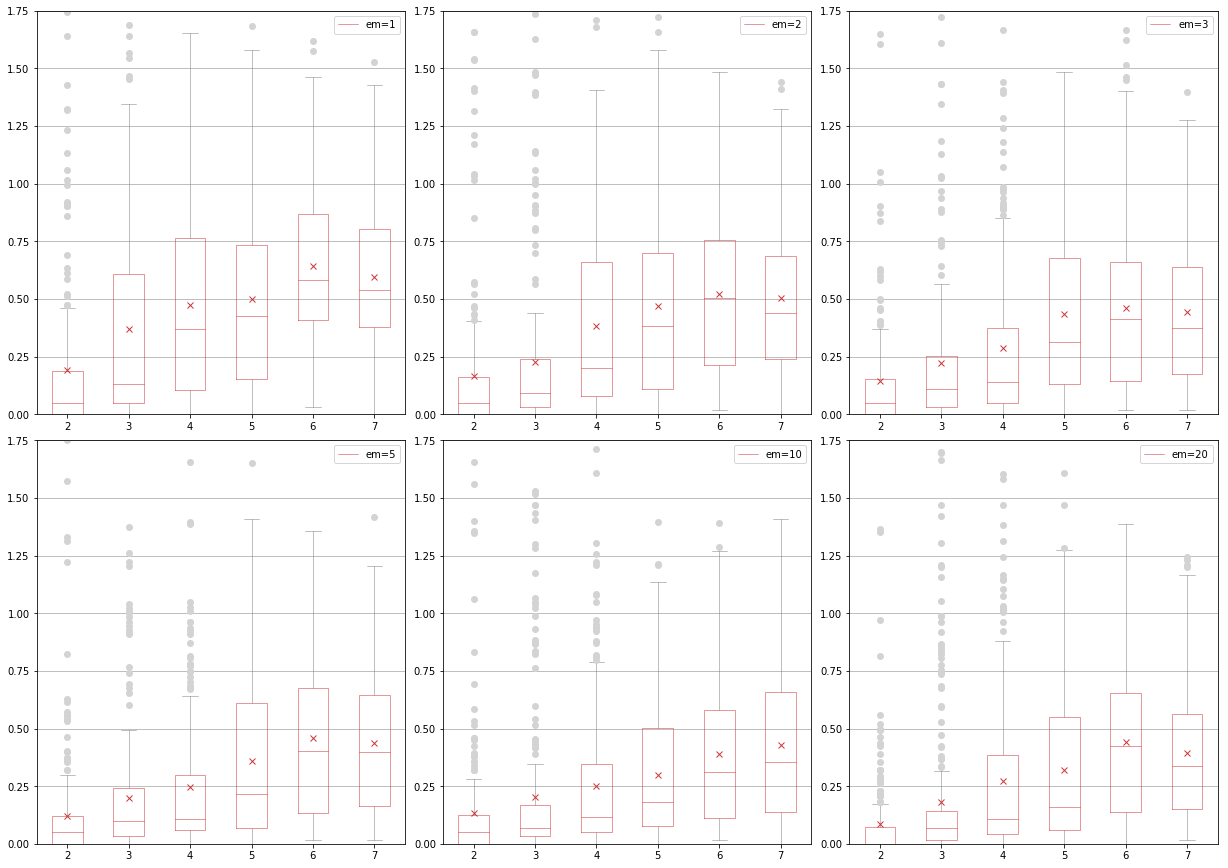

In [10]:
# Print Boxplots
ax, i = init_grid((2,3),(17,12))
for val in dfp.index.values:
    dftt = dft[dft[var]==val]
    try:
        bp = dftt.boxplot('err-mean', by=["n-sources"], return_type='both', figsize=(6,  6), showmeans=True, meanline=False, ax=ax[i])
        style_boxplot(bp)
#         ax[i].set_xticklabels([2,3,4,5,6,7])
#         ax[i].set_title("{}={}".format(var,val))
        ax[i].legend(["em={}".format(int(val))])
#         ax[i].legend([Rectangle((0, 0), 0, 0, alpha=0.0)], ['em={}'.format(int(val))], handlelength=0)
        i+=1
    except ValueError:
        continue

plt.tight_layout(.5)

# if EXPORT_LATEX:
#         tikz_save("".join([PATH_LATEX_PLOTS, 'boxplot-{}-{}.tex'.format(var, int(val))]))


Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


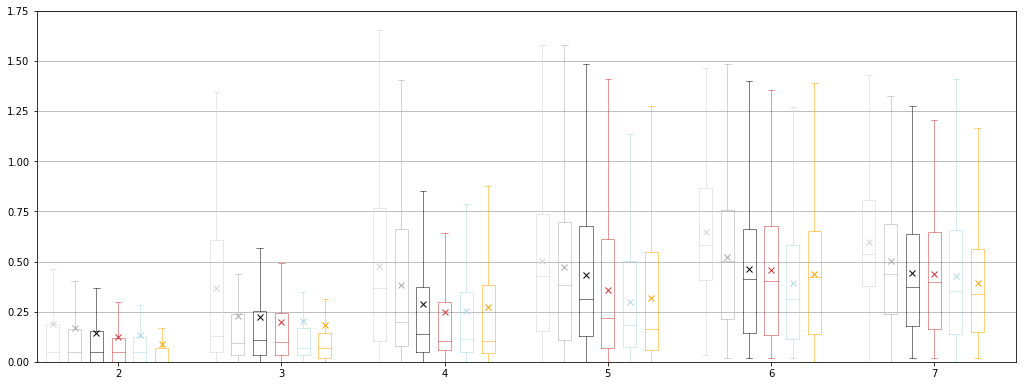

In [12]:
# Joint Boxplot, grouped
offset = 0.40
colors = ['lightgray', 'darkgray', 'k',lms_red, 'lightblue', 'orange']
offset_table = np.arange(-offset, offset, 2*offset/len(colors))
fig = figure( figsize=(17,6.5) )
ax  = fig.add_subplot(111)
boxplot_args = {'ax':ax,'notch':False,'return_type':'both','widths':0.08,'sym':'','showmeans':True, 'meanline':False}
idx=0
legend_dict = {}

for val in dfp.index.values:
    dftt = dft[dft[var]==val]
    bp = dftt.boxplot("err-mean", by=["n-sources"], **boxplot_args, whiskerprops = WHISKER_PROPS)
    legend_dict["em={}".format(int(val))] = Patch(color=colors[idx])
    style_boxplot(bp, None, colors[idx])
    boxlines = bp["err-mean"][1]
    for el in boxlines:
        setp(boxlines[el], color=colors[idx],linewidth=0.5)  # this styles elements not in box
        for el2 in boxlines[el]:
            line = el2
            setp(line, xdata=getp(line, 'xdata')+offset_table[idx])
    idx+=1
# plt.legend(list(legend_dict.values()), list(legend_dict.keys()))  # Legend is added in LaTeX!
if EXPORT_LATEX:
    tikz_save("".join([PATH_LATEX_PLOTS, 'boxplot-joined-{}.tex'.format(var)]), strict=True, wrap=False)

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


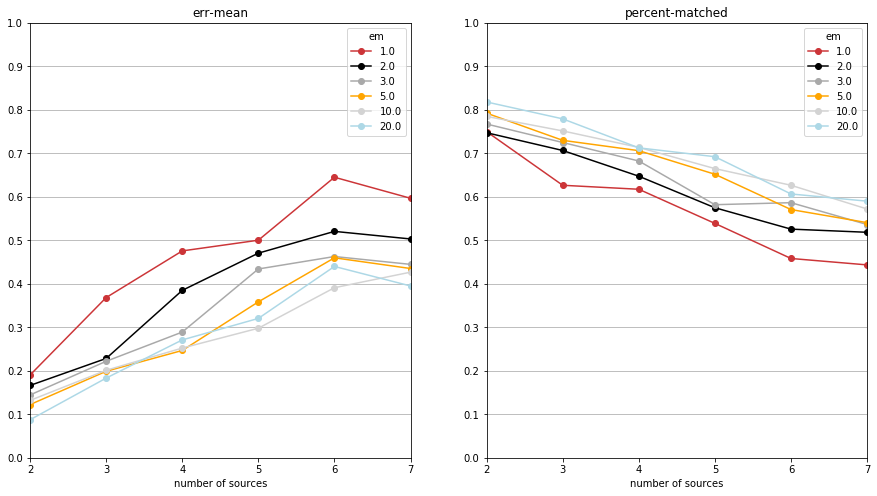

In [13]:
# Print Means in Lineplot
ax, i = init_grid((1,2),(15,8))
cols = ['err-mean', 'percent-matched']
axis_param = [[0.1, 0, 0, 1.01],[0.1, 0, 0,1.01]]
for col in cols:
    a = dft.pivot_table(col, index=['n-sources'], columns=[var], aggfunc='mean').plot(**DEFAULT_LINE_PLOT_ARGS, grid=True, ax=ax[i], title=col)
#     a.set_ylim([0,1])
    style_line_plot("number of sources", "", grid='x', ax=ax[i])
    adjust_y_axis(*axis_param[i], a)
    i+=1
    if EXPORT_LATEX:
        tikz_save("".join([PATH_LATEX_PLOTS, 'lineplot-{}-{}.tex'.format(var, col)]))

## T60

In [ ]:
df = load_all_data()

In [ ]:
# Manipulate Data
var = "T60"
dft = df
dft = dft[dft["reflect-order"]==3]
# dft = dft[dft["T60"]==0.3]
dft = dft[dft["em"]==5]
dft = dft[dft["wd"]==1.2]
dft = dft[dft["md"]==0.5]
dft = dft[dft["SNR"]==0]
dft = dft[dft["var-fixed"]==0]
dft = dft[dft["var-val"]==0.1]
# print_summary(dft)

In [ ]:
print("SAMPLE SIZE:")
dfp = dft.pivot_table("x1", index=["n-sources"], columns=[var], aggfunc='count').transpose()
print(dfp)

print("\nMEAN ERROR:")
dfp = dft.pivot_table("err-mean", index=["n-sources"], columns=var, aggfunc='mean').transpose()
print(dfp)

In [ ]:
dfp = dft.pivot_table("err-mean", index=["n-sources"], columns=var, aggfunc='mean').transpose()

# Joint Boxplot, grouped
offset = 0.25
colors = ['darkgray', 'k',lms_red, 'lightblue']
offset_table = np.arange(-offset, offset, 2*offset/len(colors))
fig = figure( figsize=(17,6.5) )
ax  = fig.add_subplot(111)
boxplot_args = {'ax':ax,'notch':False,'return_type':'both','widths':0.08,'sym':'','showmeans':True, 'meanline':False}
idx=0
legend_dict = {}

for val in dfp.index.values:
    dftt = dft[dft[var]==val]
    bp = dftt.boxplot("err-mean", by=["n-sources"], **boxplot_args, whiskerprops = whiskerprops)
    legend_dict["em={}".format(int(val))] = Patch(color=colors[idx])
    style_boxplot(bp, None, colors[idx])
    boxlines = bp["err-mean"][1]
    for el in boxlines:
        setp(boxlines[el], color=colors[idx],linewidth=0.5)  # this styles elements not in box
        for el2 in boxlines[el]:
            line = el2
            setp(line, xdata=getp(line, 'xdata')+offset_table[idx])
    idx+=1
# plt.legend(list(legend_dict.values()), list(legend_dict.keys()))  # Legend is added in LaTeX!
if EXPORT_LATEX:
    tikz_save("".join([PATH_LATEX_PLOTS, 'boxplot-joined-{}.tex'.format(var)]), strict=True, wrap=False)

In [ ]:
# Print Boxplots
ax, i = init_grid((1,len(dfp.index.values)),(17,6))
for val in dfp.index.values:
    dftt = dft[dft[var]==val]
    try:
        bp = dftt.boxplot('err-mean', by=["n-sources"], return_type='both', figsize=(6,  6), showmeans=True, meanline=True, ax=ax[i])
        style_boxplot(bp)
        ax[i].set_title("{}={}".format(var,val))
        i+=1
    except ValueError:
        continue

In [ ]:
# Print Means in Lineplot
ax, i = init_grid((1,1),(6,6))
cols = ['err-mean']#, 'percent-matched']
axis_param = [[0.2, 0, 0, 1.01],[0.1, 0, 0,1.01]]
for col in cols:
    a = dft.pivot_table(col, index=['n-sources'], columns=[var], aggfunc='mean').plot(**DEFAULT_LINE_PLOT_ARGS, grid=True, ax=ax[i], title=col)
#     a.set_ylim([0,1])
    style_line_plot("number of sources", "", grid='x', ax=ax[i])
    adjust_y_axis(*axis_param[i], a)
    i+=1
    if EXPORT_LATEX:
        tikz_save("".join([PATH_LATEX_PLOTS, 'plot_{}_{}.tex'.format(desc, col)]),
        figureheight = '\\figureheight',
        figurewidth = '\\figurewidth'
        )

# Min-Distance 

In [ ]:
df = load_all_data()

In [ ]:
var="md"
# Manipulate Data
dft = df
dft = dft[dft["reflect-order"]==3]
dft = dft[dft["T60"]==0.0]
dft = dft[dft["em"]==5]
dft = dft[dft["wd"]==1.2]
# dft = dft[dft["md"]==0.5]
dft = dft[dft["SNR"]==0]
dft = dft[dft["var-fixed"]==0]
dft = dft[dft["var-val"]==0.1]
# print_summary(dft)

In [ ]:
print("SAMPLE SIZE:")
dfp = dft.pivot_table("x1", index=["n-sources"], columns=["md"], aggfunc='count').transpose()
print(dfp)

print("\nMEAN ERROR:")
dfp = dft.pivot_table("err-mean", index=["n-sources"], columns=["md"], aggfunc='mean').transpose()
print(dfp)

In [ ]:
dfp = dft.pivot_table("err-mean", index=["n-sources"], columns=var, aggfunc='mean').transpose()

# Joint Boxplot, grouped
offset = 0.25
colors = ['darkgray', 'k',lms_red, 'lightblue']
offset_table = np.arange(-offset, offset, 2*offset/len(colors))
fig = figure( figsize=(17,6.5) )
ax  = fig.add_subplot(111)
boxplot_args = {'ax':ax,'notch':False,'return_type':'both','widths':0.08,'sym':'','showmeans':True, 'meanline':False}
idx=0
legend_dict = {}

for val in dfp.index.values:
    dftt = dft[dft[var]==val]
    bp = dftt.boxplot("err-mean", by=["n-sources"], **boxplot_args, whiskerprops = whiskerprops)
    legend_dict["em={}".format(int(val))] = Patch(color=colors[idx])
    style_boxplot(bp, None, colors[idx])
    boxlines = bp["err-mean"][1]
    for el in boxlines:
        setp(boxlines[el], color=colors[idx],linewidth=0.5)  # this styles elements not in box
        for el2 in boxlines[el]:
            line = el2
            setp(line, xdata=getp(line, 'xdata')+offset_table[idx])
    idx+=1
# plt.legend(list(legend_dict.values()), list(legend_dict.keys()))  # Legend is added in LaTeX!
if EXPORT_LATEX:
    tikz_save("".join([PATH_LATEX_PLOTS, 'boxplot-joined-{}.tex'.format(var)]), strict=True, wrap=False)

In [ ]:
spgrid = (1,4)
plt.subplots(spgrid[0],spgrid[1], figsize=(17,5))
ax = list()
for i in range(1,spgrid[0]*spgrid[1]+1):
    ax.append(plt.subplot(spgrid[0],spgrid[1],i))

i=0
for md in [.1,.3,.5,1.]:
    dftt = dft[dft["md"]==md]
    try:
        bp = dftt.boxplot('err-mean', by=["n-sources"], return_type='both', figsize=(6,  6), showmeans=True, meanline=True, ax=ax[i])
        style_boxplot(bp)
        ax[i].set_title("min-distance={}".format(md))
        i+=1
    except ValueError:
        continue

In [ ]:
spgrid = (1,2)
plt.subplots(spgrid[0],spgrid[1], figsize=(17,6))
ax = list()
for i in range(1,spgrid[0]*spgrid[1]+1):
    ax.append(plt.subplot(spgrid[0],spgrid[1],i))

i=0
desc = "md"
cols = ['err-mean', 'percent-matched']
axis_param = [[0.1, 0, 0, 1.01],[0.1, 0, 0,1.01]]
for col in cols:
    a = dft.pivot_table(col, index=['n-sources'], columns=desc, aggfunc='mean').plot(**DEFAULT_LINE_PLOT_ARGS, grid=True, ax=ax[i], title=col)
    a.set_ylim([0,1])
    style_line_plot("number of sources", "", grid='x', ax=ax[i])
    adjust_y_axis(*axis_param[i], a)
    i+=1
    if EXPORT_LATEX:
        tikz_save("".join([PATH_LATEX_PLOTS, 'plot_{}_{}.tex'.format(desc, col)]),
        figureheight = '\\figureheight',
        figurewidth = '\\figurewidth'
        )

# Reflect Order

In [ ]:
df = load_all_data()

In [ ]:
# Manipulate Data
var = "reflect-order"
dft = df
# dft = dft[dft["reflect-order"]==3]
dft = dft[dft["T60"]==0.6]
dft = dft[dft["em"]==5]
dft = dft[dft["wd"]==1.2]
dft = dft[dft["md"]==0.5]
dft = dft[dft["SNR"]==0]
dft = dft[dft["var-fixed"]==0]
dft = dft[dft["var-val"]==0.1]
# print_summary(dft)

In [ ]:
print("SAMPLE SIZE:")
dfp = dft.pivot_table("x1", index=["n-sources"], columns=["reflect-order"], aggfunc='count').transpose()
print(dfp)

print("\nMEAN ERROR:")
dfp = dft.pivot_table("err-mean", index=["n-sources"], columns=["reflect-order"], aggfunc='mean').transpose()
print(dfp)

In [ ]:
dfp = dft.pivot_table("err-mean", index=["n-sources"], columns=var, aggfunc='mean').transpose()
# Joint Boxplot, grouped
offset = 0.15
colors = ['darkgray', 'k',lms_red]
offset_table = np.linspace(-offset, offset, len(dfp.index.values))
fig = figure( figsize=(17,6.5) )
ax  = fig.add_subplot(111)
boxplot_args = {'ax':ax,'notch':False,'return_type':'both','widths':0.08,'sym':'','showmeans':True, 'meanline':False}
idx=0
legend_dict = {}

for val in [1, 3, -1]:  # custom values to sort -1 as maximum value!
    dftt = dft[dft[var]==val]
    bp = dftt.boxplot("err-mean", by=["n-sources"], **boxplot_args, whiskerprops = whiskerprops)
    legend_dict["em={}".format(int(val))] = Patch(color=colors[idx])
    style_boxplot(bp, None, colors[idx])
    boxlines = bp["err-mean"][1]
    for el in boxlines:
        setp(boxlines[el], color=colors[idx],linewidth=0.5)  # this styles elements not in box
        for el2 in boxlines[el]:
            line = el2
            setp(line, xdata=getp(line, 'xdata')+offset_table[idx])
    idx+=1
# plt.legend(list(legend_dict.values()), list(legend_dict.keys()))  # Legend is added in LaTeX!
if EXPORT_LATEX:
    tikz_save("".join([PATH_LATEX_PLOTS, 'boxplot-joined-{}.tex'.format(var)]), strict=True, wrap=False)

In [ ]:
ax, i = init_grid((1,3),(17,5))
for val in [1., 3., -1.]:
    dftt = dft[dft[var]==val]
    try:
        bp = dftt.boxplot('err-mean', by=["n-sources"], return_type='both', figsize=(6,  6), showmeans=True, meanline=True, ax=ax[i])
        style_boxplot(bp)
        ax[i].set_title("{}={}".format(var, val))
        i+=1
    except ValueError:
        continue

In [ ]:
ax, i = init_grid((1,2),(17,6))
desc = "reflect-order"
cols = ['err-mean', 'percent-matched']
axis_param = [[0.2, 0, 0, 2.01],[0.1, 0, 0,1.01]]
for col in cols:
    a = dft.pivot_table(col, index=['n-sources'], columns=['reflect-order'], aggfunc='mean').plot(**DEFAULT_LINE_PLOT_ARGS, grid=True, ax=ax[i], title=col)
#     a.set_ylim([0,1])
    style_line_plot("number of sources", "", grid='x', ax=ax[i])
    adjust_y_axis(*axis_param[i], a)
    i+=1
    if EXPORT_LATEX:
        tikz_save("".join([PATH_LATEX_PLOTS, 'plot_{}_{}.tex'.format(desc, col)]),
        figureheight = '\\figureheight',
        figurewidth = '\\figurewidth'
        )

## SNR

In [ ]:
df = load_all_data()

In [ ]:
var = "SNR"
# Manipulate Data
dft = df
dft = dft[dft["reflect-order"]==3]
dft = dft[dft["T60"]==0.3]
dft = dft[dft["em"]==5]
dft = dft[dft["wd"]==1.2]
dft = dft[dft["md"]==0.5]
# dft = dft[dft["SNR"]==0]
dft = dft[dft["var-fixed"]==0]
dft = dft[dft["var-val"]==0.1]
dft = dft[dft["description"]=="noise"]
print_summary(dft)

In [ ]:
print("SAMPLE SIZE:")
dfp = dft.pivot_table("x1", index=["n-sources"], columns=[var], aggfunc='count').transpose()
print(dfp)

print("\nMEAN ERROR:")
dfp = dft.pivot_table("err-mean", index=["n-sources"], columns=var, aggfunc='mean').transpose()
print(dfp)

In [ ]:
dfp = dft.pivot_table("err-mean", index=["n-sources"], columns=var, aggfunc='mean').transpose()
# Joint Boxplot, grouped
offset = 0.25
colors = ['darkgray', 'k',lms_red, 'lightblue',"orange"]
offset_table = np.linspace(-offset, offset, len(dfp.index.values))
fig = figure( figsize=(17,6.5) )
ax  = fig.add_subplot(111)
boxplot_args = {'ax':ax,'notch':False,'return_type':'both','widths':0.08,'sym':'','showmeans':True, 'meanline':False}
idx=0
legend_dict = {}
for val in [0,30,15,10,5]:
    dftt = dft[dft[var]==val]
    bp = dftt.boxplot("err-mean", by=["n-sources"], **boxplot_args, whiskerprops = whiskerprops)
    legend_dict["em={}".format(int(val))] = Patch(color=colors[idx])
    style_boxplot(bp, None, colors[idx])
    boxlines = bp["err-mean"][1]
    for el in boxlines:
        setp(boxlines[el], color=colors[idx],linewidth=0.5)  # this styles elements not in box
        for el2 in boxlines[el]:
            line = el2
            setp(line, xdata=getp(line, 'xdata')+offset_table[idx])
    idx+=1
# plt.legend(list(legend_dict.values()), list(legend_dict.keys()))  # Legend is added in LaTeX!
if EXPORT_LATEX:
    tikz_save("".join([PATH_LATEX_PLOTS, 'boxplot-joined-{}.tex'.format(var)]), strict=True, wrap=False)

In [ ]:
ax, i = init_grid((1,5),(17,4))
for val in dfp.index.values:
    dftt = dft[dft[var]==val]
    try:
        bp = dftt.boxplot('err-mean', by=["n-sources"], return_type='both', figsize=(6,  6), showmeans=True, meanline=True, ax=ax[i])
        style_boxplot(bp)
        ax[i].set_title("{}={}".format(var,val))
        i+=1
    except ValueError:
        continue

In [ ]:
ax, i = init_grid((1,2),(17,6))
cols = ['err-mean', 'percent-matched']
axis_param = [[0.2, 0, 0, 2.01],[0.1, 0, 0,1.01]]
for col in cols:
    a = dft.pivot_table(col, index=['n-sources'], columns=[var], aggfunc='mean').plot(**DEFAULT_LINE_PLOT_ARGS, grid=True, ax=ax[i], title=col)
#     a.set_ylim([0,1])
    style_line_plot("number of sources", "", grid='x', ax=ax[i])
#     adjust_y_axis(*axis_param[i], a)
    i+=1
    if EXPORT_LATEX:
        tikz_save("".join([PATH_LATEX_PLOTS, 'plot_{}_{}.tex'.format(desc, col)]),
        figureheight = '\\figureheight',
        figurewidth = '\\figurewidth'
        )

## Guessing at random

In [ ]:
dft = matlab2pandas(dirname='_guessing', save_to=path.join(PATH_ROOT, desc), summary=False)

In [ ]:
dft = dft[dft['description'].isin(['_guessing', 'base'])]
print_summary(dft)
dfp = dft.pivot_table("err-mean", index="description", columns="n-sources", aggfunc='mean').transpose()
dfp.plot(kind='line', marker='o', color=[lms_red, "darkgray", "lightgray", "orange", "black"])

style_line_plot(xlabel="number of sources", ylabel="mean localisation error [m]", grid="y")

# Wall distance

In [ ]:
df = load_all_data()
dft = df

In [ ]:
var = "wd"
# Manipulate Data
dft = df
dft = dft[dft["reflect-order"]==3]
dft = dft[dft["T60"]==0.3]
dft = dft[dft["em"]==5]
# dft = dft[dft["wd"]==1.2]
dft = dft[dft["md"]==0.5]
dft = dft[dft["SNR"]==0]
dft = dft[dft["var-fixed"]==0]
dft = dft[dft["var-val"]==0.1]
print_summary(dft)
# dfp = df.pivot_table("err-mean", index=["description", "wd"], columns="n-sources", aggfunc='mean').transpose()
# dfp.boxplot(column=("n-sources"))

In [ ]:
dfp = dft.pivot_table("err-mean", index=["n-sources"], columns=var, aggfunc='mean').transpose()

# Joint Boxplot, grouped
offset = 0.15
colors = ['darkgray', 'k',lms_red, 'lightblue']
offset_table = np.linspace(-offset, offset, len(dfp.index.values))
fig = figure( figsize=(17,6.5) )
ax  = fig.add_subplot(111)
boxplot_args = {'ax':ax,'notch':False,'return_type':'both','widths':0.08,'sym':'','showmeans':True, 'meanline':False}
idx=0
legend_dict = {}

for val in dfp.index.values:
    dftt = dft[dft[var]==val]
    bp = dftt.boxplot("err-mean", by=["n-sources"], **boxplot_args, whiskerprops = whiskerprops)
    legend_dict["em={}".format(int(val))] = Patch(color=colors[idx])
    style_boxplot(bp, None, colors[idx])
    boxlines = bp["err-mean"][1]
    for el in boxlines:
        setp(boxlines[el], color=colors[idx],linewidth=0.5)  # this styles elements not in box
        for el2 in boxlines[el]:
            line = el2
            setp(line, xdata=getp(line, 'xdata')+offset_table[idx])
    idx+=1
# plt.legend(list(legend_dict.values()), list(legend_dict.keys()))  # Legend is added in LaTeX!
if EXPORT_LATEX:
    tikz_save("".join([PATH_LATEX_PLOTS, 'boxplot-joined-{}.tex'.format(var)]), strict=True, wrap=False)

In [ ]:
ax, i = init_grid((1,3), (17,8))
for val in [1.2, 1.3, 1.5]:
    dftt = dft[dft[var]==val]
    bp = dftt.boxplot('err-mean', by=["n-sources"], return_type='both', figsize=(6,  6), ax=ax[i],showmeans=True, meanline=True)
    style_boxplot(bp)
    ax[i].set_title("Wall distance = {}m".format(val))
    i+=1

In [ ]:
ax, i = init_grid((2,2),(17,17))
cols = ['err-mean', 'percent-matched']
axis_param = [[0.1, 0, 0, 1.01],[0.1, 0, 0,1.01]]
for vf in [1, 0]:
    dftt = dft[dft["var-fixed"]==vf]
    for col in cols:
        a = dftt.pivot_table(col, index=['n-sources'], columns=['var-val', 'var-fixed'], aggfunc='mean').plot(**DEFAULT_LINE_PLOT_ARGS, grid=True, ax=ax[i], title=col)
        a.set_ylim([0,1])
        style_line_plot("number of sources", "", grid='x', ax=ax[i])
        adjust_y_axis(*axis_param[i], a)
        i+=1
        if EXPORT_LATEX:
            tikz_save("".join([PATH_LATEX_PLOTS, 'plot_{}_{}.tex'.format(desc, col)]),
            figureheight = '\\figureheight',
            figurewidth = '\\figurewidth'
            )

# Best Case Scenario vs. Worst Case Scenario

In [ ]:
df = load_all_data()

In [ ]:
var = "wd"
dfts = []

print("BEST CASE SCENARIO:")
# Manipulate Data
dft = df
dft = dft[dft["reflect-order"]==0]
dft = dft[dft["T60"]==0.0]
dft = dft[dft["em"]==5]
dft = dft[dft["wd"]==1.5]
dft = dft[dft["md"]==0.5]
dft = dft[dft["SNR"]==0]
dft = dft[dft["var-fixed"]==0]
dft = dft[dft["var-val"]==0.1]
print_summary(dft)
dfts.append(dft)

print("BASE SCENARIO:")
# Manipulate Data
dft = df
dft = dft[dft["reflect-order"]==3]
dft = dft[dft["T60"]==0.3]
dft = dft[dft["em"]==5]
dft = dft[dft["wd"]==1.2]
dft = dft[dft["md"]==0.5]
dft = dft[dft["SNR"]==0]
dft = dft[dft["var-fixed"]==0]
dft = dft[dft["var-val"]==0.1]
print_summary(dft)
dfts.append(dft)

print("WORST CASE SCENARIO:")
# Manipulate Data
dft = df
dft = dft[dft["reflect-order"]==-1]
dft = dft[dft["T60"]==0.9]
dft = dft[dft["em"]==5]
dft = dft[dft["wd"]==1.2]
dft = dft[dft["md"]==0.5]
dft = dft[dft["SNR"]==5]
dft = dft[dft["var-fixed"]==0]
dft = dft[dft["var-val"]==0.1]
print_summary(dft)
dfts.append(dft)

print("GUESSING:")
dft = matlab2pandas(dirname='_guessing', save_to=path.join(PATH_ROOT, '_guessing'), summary=True)
dfts.append(dft)

In [ ]:
# Joint Boxplot, grouped
offset = 0.15
colors = ['darkgray', 'k',lms_red, 'lightblue']
offset_table = np.linspace(-offset, offset, 4)
fig = figure( figsize=(17,6.5) )
ax  = fig.add_subplot(111)
boxplot_args = {'ax':ax,'notch':False,'return_type':'both','widths':0.08,'sym':'','showmeans':True, 'meanline':False}
idx=0
legend_dict = {}

for dft in dfts:
    dftt = dft
    bp = dftt.boxplot("err-mean", by=["n-sources"], **boxplot_args)
    legend_dict["em={}".format(int(val))] = Patch(color=colors[idx])
    style_boxplot(bp, None, colors[idx])
    boxlines = bp["err-mean"][1]
    for el in boxlines:
        setp(boxlines[el], color=colors[idx],linewidth=0.5)  # this styles elements not in box
        for el2 in boxlines[el]:
            line = el2
            setp(line, xdata=getp(line, 'xdata')+offset_table[idx])
    idx+=1
    
# plt.legend(list(legend_dict.values()), list(legend_dict.keys()))  # Legend is added in LaTeX!
# adjust axis to larger values of guessing and worst case scenario
ax.set_ylim([0,3.51])
ax.set_yticks(np.arange(0,3.51,0.25))

if EXPORT_LATEX:
    tikz_save("".join([PATH_LATEX_PLOTS, 'boxplot-joined-best-case.tex'.format(var)]), strict=True, wrap=False)

In [ ]:
ax, i = init_grid((1,4), (17,7))
desc = ['best case', 'base', 'worst case', 'guessing']
for dft in dfts:
    dftt = dft
    bp = dftt.boxplot('err-mean', by=["n-sources"], return_type='both', figsize=(6,  6), ax=ax[i],showmeans=True, meanline=True)
    style_boxplot(bp)
    adjust_y_axis(0.25,2,0,3.51,ax[i])
    ax[i].set_title("{}".format(desc[i]))
    i+=1
if EXPORT_LATEX:
    tikz_save("".join([PATH_LATEX_PLOTS, 'boxplot-seperate-cases.tex'.format(var)]), strict=True, wrap=False)

# Variance Analysis

In [ ]:
# Load Data
dfs = []
for desc in EVALUATIONS:
    dfs.append(matlab2pandas(dirname=desc, save_to=path.join(PATH_ROOT, desc), summary=False))
try:
    df = pd.concat(dfs)
except ValueError:
    df = dfs

In [ ]:
# Manipulate Data
dft = df
dft = dft[dft["reflect-order"]==3]
dft = dft[dft["T60"]==0.3]
dft = dft[dft["em"]==10]
dft = dft[dft["wd"]==1.2]
dft = dft[dft["md"]==0.5]
dft = dft[dft["SNR"]==0]
# print_summary(dft)

In [ ]:
# Sample Sizes
dfp = dft.pivot_table("x1", index=["n-sources"], columns=["var-val","var-fixed"], aggfunc='count').transpose()
print(dfp)

In [ ]:
# dfp = df.pivot_table("err-mean", index=["description", "wd"], columns="n-sources", aggfunc='mean').transpose()
# dfp.boxplot(column=("n-sources", "var", "var-val"))
ax, i = init_grid((2,6),(17,8))
for vv, vf in [(0.1,1), (0.5,1), (1.0,1), (2.0,1), (3.0,1),(5.0,1), (0.1, 0), (0.5, 0), (1.0, 0), (2.0, 0), (3.0, 0), (5.0, 0)]:
    dftt = dft[dft["var-val"]==vv]
    dftt = dftt[dftt["var-fixed"]==vf]
    try:
        bp = dftt.boxplot('err-mean', by=["n-sources"], return_type='both', figsize=(6,  6), showmeans=True, meanline=True, ax=ax[i])
        style_boxplot(bp)
        ax[i].set_title("var-fixed={}, var-val={}".format(vf, vv))
        i+=1
    except ValueError:
        continue
    

In [ ]:
ax, i = init_grid((2,2),(17,17))
cols = ['err-mean', 'percent-matched']
axis_param = [[0.1, 0, 0, 1.01],[0.1, 0, 0,1.01],[0.1, 0, 0, 1.01],[0.1, 0, 0,1.01]]
for vf in [1, 0]:
    dftt = dft[dft["var-fixed"]==vf]
    for col in cols:
        a = dftt.pivot_table(col, index=['n-sources'], columns=['var-val', 'var-fixed'], aggfunc='mean').plot(**DEFAULT_LINE_PLOT_ARGS, grid=True, ax=ax[i], title=col)
        a.set_ylim([0,1])
        style_line_plot("number of sources", "", grid='x', ax=ax[i])
        adjust_y_axis(*axis_param[i], a)
        i+=1
        if EXPORT_LATEX:
            tikz_save("".join([PATH_LATEX_PLOTS, 'plot_{}_{}.tex'.format(desc, col)]),
            figureheight = '\\figureheight',
            figurewidth = '\\figurewidth'
            )

# Analyse DataFrame

### Examine Outliers

In [ ]:
# print(pd.concat([df[df["err-mean"]>=1.5].loc[:, "err1":"err7"], df[df["err-mean"]>=1.5].loc[:, "x1":"x7"]], axis=1))
print("ERRORS:\n{}\n".format(df[df["err-mean"]>=1.5].loc[:, "err1":"err7"]))
print("X-COORDINATES:\n{}\n".format(df[df["err-mean"]>=1.5].loc[:, "x1":"x7est"]))
print("Y-COORDINATES:\n{}\n".format(df[df["err-mean"]>=1.5].loc[:, "y1":"y7est"]))

In [ ]:
# Box Plot
bp = df.boxplot('err-mean', by=["n-sources", "refl-ord"], return_type='both',figsize=(17,  12), showmeans=True, meanline=True)
style_boxplot(bp)

if EXPORT_LATEX:
    tikz_save(PATH_BOX_PLOT, show_info=False)

# Perfect Match Analysis

In [ ]:
dfcp = df.pivot_table("percent-matched", columns="refl-ord", aggfunc='mean').transpose()
dfcp.plot(**DEFAULT_LINE_PLOT_ARGS)
# Style plot
style_line_plot(xlabel="number of sources", ylabel="perfect matches", grid="y")

# Significance Analysis

In [ ]:
from scipy.stats import ttest_ind, describe, norm
from statsmodels.formula.api import ols

means = []
stddevs = []

# extract err-mean per n_sources
cat = {}
for n in set(df["n-sources"].values):
    cat[str(n)] = df[df['n-sources']==n]['err-mean']

x = np.linspace(0,1.5,100)
print("DESCRIPTIVE ANALYSIS:")
fig, ax = plt.subplots(1,3, figsize=(17,  6))
for n, c in cat.items():
    dr = describe(c)
    means.append(dr.mean)
    stddevs.append(np.sqrt(dr.variance))
    y = norm.pdf(x, loc=dr.mean, scale=np.sqrt(dr.variance))
    plt.subplot(131)
    plt.plot(x, y, label=n)  # plot gaussian
    print("{} sources: n={:3}, min={:0.3f}, max={:0.3f}, mean={:0.3f}, variance={:0.3f}, std.dev={:0.3f}".format(
        n, dr.nobs, dr.minmax[0], dr.minmax[1], dr.mean, dr.variance, np.sqrt(dr.variance)))
plt.legend()

plt.subplot(132)
plt.boxplot(list(cat.values()), showmeans=True, meanline=True)

plt.subplot(133)
plt.boxplot(list(cat.values()), showmeans=True, meanline=True)
plt.ylim(-0.01, 0.31)
plt.yticks([0, 0.1, 0.2, 0.3])

# This means that given p and t values from a two-tailed test, you would reject the null hypothesis 
# of a greater-than test when p/2 < alpha and t > 0, and of a less-than test when p/2 < alpha and t < 0.    

print("\nT-TEST FOR DIFFERENCE IN MEANS:")
for i1 in set(df["n-sources"].values):
    for i2 in set(df["n-sources"].values):
        if i1!=i2 and i2>i1 and i2<=i1+1:
            ttest = ttest_ind(cat[str(i2)], cat[str(i1)], equal_var=False)
            p_onesided = ttest.pvalue/2
            if p_onesided <= 0.01:sign="***"
            elif p_onesided <= 0.05: sign="**"
            elif p_onesided <= 0.10: sign="*"
            else: sign="(n.s.)"
            print("{}x{}: t={t.statistic:0.3f}, p={p:0.3f} {s:^6}".format(i1, i2, t=ttest, p=p_onesided, s=sign))

print("\nVISUALIZE MEANS AND VARIANCE OF DATA:")

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle

x = np.linspace(0, 1)
p1, = plt.plot(x, np.cos(x))

